#UNET 

##Como es una UNet?

###Que es una UNet?
Existen diferentes métodos para resolver los problemas de segmentación semántica. Los enfoques tradicionales consisten en detectar puntos, líneas o bordes. También es posible basarse en la morfología o reunir grupos de píxeles.

Las redes neuronales convolucionales de Deep Learning ahora se utilizan de manera generalizada. Pueden abordar problemas más complejos gracias a la segmentación de imágenes.

Una de las redes neuronales más utilizadas para la segmentación de imágenes es U-NET. Se trata de un modelo de red neuronal totalmente convolucional. Este modelo fue desarrollado originalmente por Olaf Ronneberger, Phillip Fischer y Thomas Brox en 2015 para la segmentación de imágenes médicas.

La arquitectura de U-NET consta de dos «vías». La primera es la de la contracción, también llamada codificador. Se utiliza para captar el contexto de una imagen.

En realidad, se trata de un conjunto de capas de convolución y de capas de «max pooling» que permiten crear un mapa de características de una imagen y reducir su tamaño para disminuir el número de parámetros de la red.

La segunda vía es la de la de expansión simétrica, también llamada descodificador. También permite una localización precisa mediante la convolución transpuesta.

###Las ventajas de U-NET
En el campo del Deep Learning, es necesario emplear grandes series de datos para entrenar modelos. Puede resultar difícil reunir esos volúmenes de datos para resolver un problema de clasificación de imágenes, en términos de tiempo, presupuesto y recursos de hardware.

El etiquetado de datos también requiere los conocimientos y la experiencia de varios desarrolladores e ingenieros. Este caso se da sobre todo en los campos de gran especialización, como en el diagnóstico médico.

U-NET permite solucionar esos problemas, ya que es eficaz incluso con una serie de datos limitada. También ofrece una mayor precisión que los modelos convencionales.

Una arquitectura de autocodificador clásico reduce el tamaño de la información de entrada y las capas siguientes. La descodificación empieza después, se aprende la representación lineal de características y el tamaño de la trama aumenta gradualmente. Al final de esta arquitectura, el tamaño de salida es igual al de entrada.

Esta arquitectura es ideal para preservar el tamaño inicial. El problema es que comprime la entrada de forma lineal, lo que impide la transmisión de todas las características.

Aquí es donde U-NET se impone con su arquitectura en forma de U. La deconvolución se realiza en el lado del decodificador, lo que permite evitar el problema del cuello de botella que se produce con una arquitectura de autocodificador y, por tanto, evita la pérdida de características.

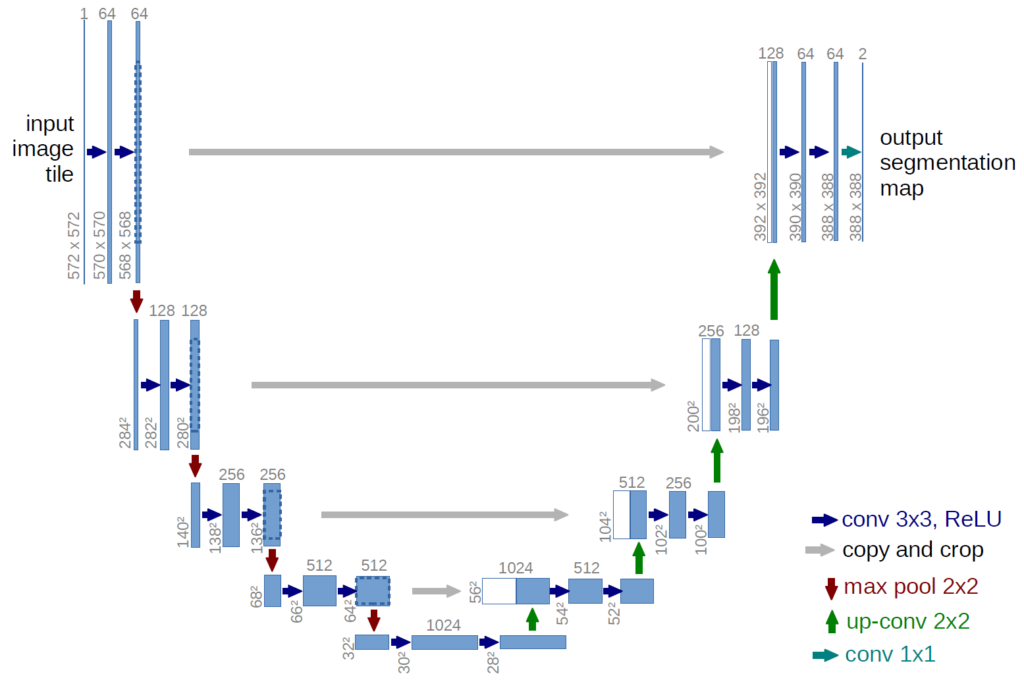

###Webgrafia
https://datascientest.com/es/u-net-lo-que-tienes-que-saber

##Nuestro Modelo


### Importación de Librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
import glob
import os
import cv2 as c
from tensorflow import keras
from tensorflow.keras.utils import load_img, array_to_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image


In [ ]:
drive.mount('/Drive/', force_remount=True)


Mounted at /Drive/


###Definición de variables globales

In [ ]:
IMG_WIDTH_HEIGHT = 256
IMG_CHANNELS = 3

###Lectura de imagenes

In [ ]:
path = '/Drive/MyDrive/90569/beachlitter_dataset_2022/beachlitter/'
dim = (256, 256)

Y = np.zeros((len(glob.glob(path+"maskpngs/*.png")), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 9), dtype=np.uint8)
for i, img in enumerate(glob.glob(path+"maskpngs/*.png")):
  im = Image.open(img).resize((256,256))
  im = to_categorical(im,9)
  #img = c.imread(img, 0)
  #resized = c.resize(img, dim, interpolation = c.INTER_AREA)
  #n = resized > 5 #PARA PASAR A BINARIO
  Y[i] = im

X = np.zeros((len(glob.glob(path+"images/*.jpg")), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 3), dtype=np.uint8)

for i, img in enumerate(glob.glob(path+"images/*.jpg")):
  img = c.imread(img)
  resized = c.resize(img, dim, interpolation = c.INTER_AREA)
  X[i] = resized



In [ ]:
X.shape
Y.shape

(3500, 256, 256, 9)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
y_train.shape

NameError: ignored

### Creación de la UNet


In [ ]:
def convolutional_block(inputs=None, n_filters=8, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    #conv = BatchNormalization()(conv)
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=8):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    return conv

def unet_model(input_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, IMG_CHANNELS), n_filters=4, n_classes=9):
    
    inputs = Input(input_size)
    c_block0 = BatchNormalization()(inputs)
    #contracting path
    cblock1 = convolutional_block(c_block0, n_filters)
    cblock2 = convolutional_block(cblock1[0], 2*n_filters)
    cblock3 = convolutional_block(cblock2[0], 4*n_filters)
    cblock4 = convolutional_block(cblock3[0], 8*n_filters, dropout_prob=0.2) 
    cblock5 = convolutional_block(cblock4[0],16*n_filters, dropout_prob=0.2, max_pooling=None)     
    middle_block = BatchNormalization()(cblock5[0])
    #expanding path
    ublock6 = upsampling_block(middle_block, cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_classes,
                 1,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    #conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation = 'softmax')(conv9) 
    conv10 = Activation('softmax')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model



In [ ]:
unet = unet_model((IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, IMG_CHANNELS), n_classes=9)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 4)  112         ['batch_normalization[0][0]']    
                                                                                              

###Entrenamiento del modelo

In [ ]:
EPOCHS = 60

unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
model_history = unet.fit(X_train, y_train, validation_split=0.1, batch_size=128, epochs=EPOCHS, callbacks=[earlystopper])

Epoch 1/60
20/20 [==============================] - 33s 925ms/step - loss: 2.2629 - accuracy: 0.3501 - val_loss: 2.1888 - val_accuracy: 0.5292
Epoch 2/60
20/20 [==============================] - 13s 629ms/step - loss: 2.1804 - accuracy: 0.5629 - val_loss: 2.1752 - val_accuracy: 0.5368
Epoch 3/60
20/20 [==============================] - 13s 628ms/step - loss: 2.1676 - accuracy: 0.5671 - val_loss: 2.1630 - val_accuracy: 0.5391
Epoch 4/60
20/20 [==============================] - 13s 631ms/step - loss: 2.1542 - accuracy: 0.5689 - val_loss: 2.1498 - val_accuracy: 0.5402
Epoch 5/60
20/20 [==============================] - 13s 638ms/step - loss: 2.1393 - accuracy: 0.5685 - val_loss: 2.1351 - val_accuracy: 0.5403
Epoch 6/60
20/20 [==============================] - 13s 640ms/step - loss: 2.1221 - accuracy: 0.5675 - val_loss: 2.1166 - val_accuracy: 0.5411
Epoch 7/60
20/20 [==============================] - 13s 636ms/step - loss: 2.0987 - accuracy: 0.5696 - val_loss: 2.0993 - val_accuracy: 0.5442

###Guardar y Cargar modelo

In [ ]:
unet.save("modelo.h5")

In [ ]:
unet= keras.models.load_model('modelo.h5')

###Predicción

In [ ]:
y = unet.predict([X_test[0, :,:, 3]])

ValueError: ignored

In [ ]:
#plt.imshow(np.argmax(y, axis=3)[0])
a = np.zeros((IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, IMG_CHANNELS))

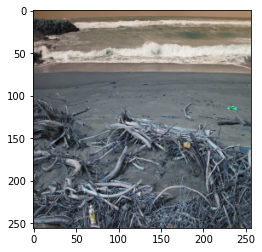

In [ ]:
plt.imshow(X_test[0])

In [ ]:
np.argmax(y, axis=0).shape

(256, 256, 9)